## MSDS 7331: Data Mining

## Mini Lab: Logistic Regression and SVMs

## 9 June 2019

## Authors: Meredith Ludlow, Anand Rajan, Kristen Rollins, and Tej Tenmattam

---

### Create Models

<div class="alert alert-block alert-info">
<b>Rubric 1:</b> Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe.
</div>

The classification task for our 2017 census dataset is to predict whether a given census tract has a high or a low unemployment rate. This is an important task, as it enables certain areas to be flagged as needing economic development or aid. Below, we first prepared our data for classification by cleaning it (in the same way as Lab 1), as well as removing unnecessary and redundant variables. We then split the data into training (80%) and testing (20%) sets, while utilizing 10-fold cross-validation. We created several logistic regression models with varying parameters, as well as some support vector machine models. We did an additional run of the models with a more reduced dataset to compare performance.

#### Preparing Data

In [108]:
# importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Set seaborn plot styles
sns.set_style('darkgrid')
sns.set_color_codes('muted')

#TODO uncomment when ready to turn in report
#import warnings
#warnings.filterwarnings("ignore") # ignore warnings for clean report

# df.head() displays all the columns without truncating
pd.set_option('display.max_columns', None)

# read csv file as pandas dataframe
df_17_census = pd.read_csv('Data/acs2017_census_tract_data.csv')

In [109]:
# Clean dataset as in lab 1
df_17_census.set_index('TractId', inplace=True) # set tract id as index

# Drop tracts where population is 0
df_17_cln = df_17_census.drop(df_17_census[df_17_census.TotalPop == 0].index)

# Drop tracts where child poverty or unemployment is null
df_17_cln = df_17_cln[np.isfinite(df_17_cln['ChildPoverty'])]
df_17_cln = df_17_cln[np.isfinite(df_17_cln['Unemployment'])]

# Impute to the median by each state
df_grouped = df_17_cln.groupby('State').transform(lambda x: x.fillna(x.median()))
df_17_cln['Income'] = df_grouped['Income']
df_17_cln['IncomeErr'] = df_grouped['IncomeErr']

# Impute remaining values to the overall median
df_17_cln = df_17_cln.fillna(df_17_cln.median())

In [110]:
# Categorize the unemployed percentages into binary categories
# Make cutoff using median of clean dataset, so groups are roughly equal
df_17_cln['HighUnemployment'] = pd.cut(df_17_cln.Unemployment,[-1,6,101],labels=[0,1])                                 
df_17_cln.HighUnemployment = df_17_cln.HighUnemployment.astype(np.int)
# 0 indicates low unemployment rate, 1 indicates high unemployment rate

df_17_cln.info() # matches cleaned dataset from lab 1

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72889 entries, 1001020100 to 72153750602
Data columns (total 37 columns):
State               72889 non-null object
County              72889 non-null object
TotalPop            72889 non-null int64
Men                 72889 non-null int64
Women               72889 non-null int64
Hispanic            72889 non-null float64
White               72889 non-null float64
Black               72889 non-null float64
Native              72889 non-null float64
Asian               72889 non-null float64
Pacific             72889 non-null float64
VotingAgeCitizen    72889 non-null int64
Income              72889 non-null float64
IncomeErr           72889 non-null float64
IncomePerCap        72889 non-null float64
IncomePerCapErr     72889 non-null float64
Poverty             72889 non-null float64
ChildPoverty        72889 non-null float64
Professional        72889 non-null float64
Service             72889 non-null float64
Office              72889 

At this point we have a clean dataset with no missing values, that matches the info from the cleaned dataset we used in Lab 1. Our target variable is "HighUnemployment", with 1 signifying a tract with a high unemployment rate and a 0 indicating low unemployment. We created the cutoff between high and low unemployment to be 6 percent, which was the median value for the unemployment attribute. By using the median to separate the groups, the classes will be of roughly the same size.

Since this dataset has 37 attributes, next we eliminate some unnecessary and redundant variables to cut down on the high dimensionality of the dataset.

In [111]:
# Create dataframe to use in logistic and SVM models
df_17_model = df_17_cln.copy()

# Eliminate non-useful and redundant variables
del df_17_model['State'] # encoding would result in too many added variables
del df_17_model['County'] # encoding would result in too many added variables
del df_17_model['Men'] # redundant to keep men and women
del df_17_model['Unemployment'] # already encoded to binary

# Eliminate more variables based on correlation plot (could maybe remove more)
del df_17_model['IncomeErr'] # only need to keep one income-related variable
del df_17_model['IncomePerCap'] # only need to keep one income-related variable
del df_17_model['IncomePerCapErr'] # only need to keep one income-related variable
del df_17_model['Transit'] # drive and transit were essentially inverses
del df_17_model['PublicWork'] # private and public work were essentially inverses

# All remaining variables are ints or floats so we do not have to do one-hot encoding

# Convert columns to percentages for consistency
df_17_model['Women'] = round(df_17_model['Women']/df_17_model['TotalPop']*100,1)
df_17_model['VotingAgeCitizen'] = round(df_17_model['VotingAgeCitizen']/df_17_model['TotalPop']*100,1)
df_17_model['Employed'] = round(df_17_model['Employed']/df_17_model['TotalPop']*100,1)

print(df_17_model.info())
df_17_model.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72889 entries, 1001020100 to 72153750602
Data columns (total 28 columns):
TotalPop            72889 non-null int64
Women               72889 non-null float64
Hispanic            72889 non-null float64
White               72889 non-null float64
Black               72889 non-null float64
Native              72889 non-null float64
Asian               72889 non-null float64
Pacific             72889 non-null float64
VotingAgeCitizen    72889 non-null float64
Income              72889 non-null float64
Poverty             72889 non-null float64
ChildPoverty        72889 non-null float64
Professional        72889 non-null float64
Service             72889 non-null float64
Office              72889 non-null float64
Construction        72889 non-null float64
Production          72889 non-null float64
Drive               72889 non-null float64
Carpool             72889 non-null float64
Walk                72889 non-null float64
OtherTransp       

,TotalPop,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,SelfEmployed,FamilyWork,HighUnemployment
TractId,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1001020100,1845,51.3,2.4,86.3,5.2,0.0,1.2,0.0,76.3,67826.0,10.7,20.8,38.5,15.6,22.8,10.8,12.4,94.2,3.3,0.5,0.0,2.1,24.5,47.8,74.2,4.5,0.0,0
1001020200,2172,46.3,1.1,41.6,54.5,0.0,1.0,0.0,76.1,41287.0,22.4,35.8,30.5,24.9,22.9,6.3,15.4,90.5,9.1,0.0,0.5,0.0,22.2,39.2,75.9,9.0,0.0,0
1001020300,3385,54.7,8.0,61.4,26.5,0.6,0.7,0.4,73.3,46806.0,14.7,21.1,27.9,19.4,33.3,9.9,9.6,88.3,8.4,1.0,0.8,1.5,23.1,43.8,73.3,4.8,0.7,0
1001020400,4267,53.1,9.6,80.3,7.1,0.5,0.2,0.0,76.3,55895.0,2.3,1.7,29.0,16.6,25.8,9.1,19.5,82.3,11.2,1.5,2.9,2.1,25.9,43.3,75.8,4.5,0.0,1
1001020500,9965,49.3,0.9,77.5,16.4,0.0,3.1,0.0,72.5,68143.0,12.2,17.9,48.8,13.8,20.5,3.5,13.4,86.9,11.2,0.8,0.3,0.7,21.0,48.0,71.4,4.5,0.0,0


#### Train/Test Split

In [112]:
# Following code from Dr. Larson's Logits and SVM notebook
# Question: should we actually use cross-validation for this lab? (rubric doesn't mention it)
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'HighUnemployment' in df_17_model:
    y = df_17_model['HighUnemployment'].values # get the labels we want
    del df_17_model['HighUnemployment'] # get rid of the class label
    X = df_17_model.values # use everything else to predict
    
# 10 fold cross-validation
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=10, random_state=None, test_size=0.2, train_size=None)


#### Logistic Regression

In [113]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
# also scale variables
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()

# TODO repeat and try out different learning parameters and constants
# TODO try to fix warnings - fixed this with solver
lr_clf = LogisticRegression(penalty='l2', C=0.05, class_weight=None, solver='lbfgs') 
        #class_weight=None because unemployment groups are weighted equally

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    # scale attributes by the training set
    scl_obj.fit(X[train_indices])
    X_train_scaled = scl_obj.transform(X[train_indices]) # apply to training
    X_test_scaled = scl_obj.transform(X[test_indices]) # use training scales to adjust test set, so we're not cheating
    
    # train object
    lr_clf.fit(X_train_scaled,y[train_indices])
    # get test set precitions
    y_hat = lr_clf.predict(X_test_scaled)

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("Precision:",mt.precision_score(y[test_indices],y_hat))
    print("Recall:",mt.recall_score(y[test_indices],y_hat))
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))


====Iteration 0  ====
Precision: 0.7653782523687772
Recall: 0.7057273609762862
accuracy 0.7474276306763616
confusion matrix
 [[5807 1560]
 [2122 5089]]
====Iteration 1  ====
Precision: 0.7628458498023716
Recall: 0.6986911723753829
accuracy 0.7445465770338867
confusion matrix
 [[5836 1560]
 [2164 5018]]
====Iteration 2  ====
Precision: 0.7725828415796641
Recall: 0.7044701986754967
accuracy 0.7499657017423514
confusion matrix
 [[5827 1503]
 [2142 5106]]
====Iteration 3  ====
Precision: 0.770378345124577
Recall: 0.6925203926448223
accuracy 0.7450267526409659
confusion matrix
 [[5852 1493]
 [2224 5009]]
====Iteration 4  ====
Precision: 0.7657142857142857
Recall: 0.6977202364199269
accuracy 0.748593771436411
confusion matrix
 [[5955 1517]
 [2148 4958]]
====Iteration 5  ====
Precision: 0.7671439336850038
Recall: 0.7104969290898939
accuracy 0.7517492111400741
confusion matrix
 [[5869 1545]
 [2074 5090]]
====Iteration 6  ====
Precision: 0.7627554882664648
Recall: 0.7041229909154437
accuracy 0.

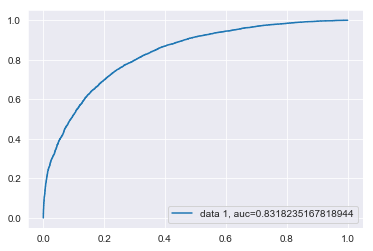

In [103]:
#ROC Curve for LR model above
y_pred_prob = lr_clf.predict_proba(X_test_scaled)[::,1]
fpr, tpr, _ = mt.roc_curve(y[test_indices],  y_pred_prob)
auc = mt.roc_auc_score(y[test_indices], y_pred_prob)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [117]:
# Influential features printing out all the coefficients
print (lr_clf.coef_)
print(np.std(X, 0)*lr_clf.coef_)

[[-0.03760259  0.06282641 -0.46278393 -1.06041758 -0.28141345 -0.04102314
  -0.21721923 -0.0593154   0.27532327 -0.17891324  0.5685759  -0.05425179
  -0.1151257   0.18070759  0.04294957 -0.05254722  0.04920473 -0.00332748
   0.05410008 -0.03363951  0.04253326 -0.06783489  0.27060649 -0.64697497
   0.04534301 -0.02394704 -0.04124028]]
[[-8.24443478e+01  2.62519017e-01 -1.06890740e+01 -3.24864126e+01
  -6.07819674e+00 -1.85634298e-01 -1.95338322e+00 -6.06836091e-02
   2.87564377e+00 -5.45540028e+03  7.11544850e+00 -1.01143971e+00
  -1.73768552e+00  1.45249138e+00  2.42815143e-01 -3.14222576e-01
   3.75398233e-01 -5.01186040e-02  2.79574376e-01 -1.81604363e-01
   1.07112539e-01 -2.59259398e-01  1.92158203e+00 -5.86248734e+00
   3.63531205e-01 -9.21013325e-02 -1.87823510e-02]]


#### Stochastic Gradient descent
Stochastic Gradient Descent is done minimizing a function tracing a path of the cost function until it reaches a minimum value.
In this machine learning the model is gradually updated to reduce the prediction error that follows.
It requires two parameters 
a. Learning rate - which limits the updates to correct the coefficient each iteration.
b. Epochs - number of times to run through the training set to update coefficients.

The logic flows as below:
First loop through the epoch
Within this loop go through each training data for epoch
for each update the coefficient for the epoch(repetitions) including the intercept.

We use numpy to the sigmoid function to arrive at the losses.

In [118]:
# defines the sigmoid function 
 
def sigmoid(x):
# calculates and  returns the sigmoid activation value for input x
    return 1.0 / (1 + np.exp(-x))

In [119]:
#defining the cost function here - uses sigmoid function to compute logistic regression cost
def cost_f(x, y, theta):
    t = x.dot(theta)
    return -np.sum(y*np.log(sigmoid(t))+(1-y)* np.log(1-sigmoid(t)))/x.shape[0]
# defined gradient cost which can also be alternately used.
def grad_cost(x,y,theta):
    t=x.dot(theta)
    return x.T.dot(y - sigmoid(t)) / x.shape[0]

#### Main part of SGD
In this part we do the training and update the model weights. The hyper parameter "learning rate" is set. It can neither be too small or too large so as to reach the minimum of loss function.
We can use values between 0 and 1 (randomly) and minimize loss and maximize prediction. If the difference between the last values of cost is less than the threshold, then we stop updating.

In [125]:
#defining the update function for training.
def update_theta(x, y, theta, lr):
    return theta + lr * grad_cost(x, y, theta)

def train(x, y, lr, iterations=100, threshold=0.0005):
    theta = np.zeros(x.shape[1])
    costs = []
    print('Started to train')
    for i in range(iterations):
        theta = update_theta(x, y, theta, lr)
        cost = cost_f(x, y, theta)
        print(f'[Training step number: {i}] — Cost function: {cost:.4f}')
        costs.append({'cost': cost, 'wts': theta})
        if i > 15 and abs(costs[-2]['cost']-costs[-1]['cost']) < threshold:
            break
        return theta, costs

In [126]:
#Now using the earlier model used for logistic regression using CV to do the training.
theta, cost = train(X_train_scaled, y[train_indices], lr=0.05)

#Now we can predict based on our model
def predict(x, theta):
    return (sigmoid(x.dot(theta)) >=0.5).astype(int)

def get_accuracy(x,y,theta):
    ypred=predict(x,theta)
    return (ypred == y).sum()/y.shape[0]

print(f'Accuracy -training:{get_accuracy(X_train_scaled, y[train_indices], theta)}')
print(f'Accuracy -test:{get_accuracy(X_test_scaled, y[test_indices], theta)}')

Started to train
[Training step number: 0] — Cost function: 0.6756
Accuracy -training:0.7310284508926275
Accuracy -test:0.7351488544381946


In [127]:
#### This is a different set of data for which we plotted the theta and cost for comparison.

from sklearn.linear_model import SGDClassifier
df_17_model2 = df_17_model.copy()
#The choice is totally manual and decided on some logic based on LDA arrived at previous work
#Ratio of Voting Age citizens to total population
df_17_model2['VotingAgeR'] = df_17_cln['VotingAgeCitizen']/df_17_cln['TotalPop']
# Ratio of Employed to total population
df_17_model2['EmpRatio'] = df_17_cln['Employed']/df_17_cln['TotalPop']

X = df_17_model2[['EmpRatio','VotingAgeR','Professional','MeanCommute']].values

if 'HighUnemployment' in df_17_model:
    y = df_17_model2['HighUnemployment'].values # get the labels we want
    del df_17_model2['HighUnemployment'] # get rid of the class label

def stochastic_gradient_descent(X,y,theta,learning_rate=0.01,n_iter=100):
#    X    = Matrix of X with added bias units; y= Vector of Y; theta=Vector of thetas np.random.randn(j,1)
#    learning_rate ;    n_iter = no of iterations
#    Returns theta and array of cost for  no of iterations

    m = len(y)
    cost_history = np.zeros(n_iter)
    
    for it in range(n_iter):
        cost =0.0
        for i in range(m):
            rand_ind = np.random.randint(0,m)
            X_i = X[rand_ind,:].reshape(1,X.shape[1])
            y_i = y[rand_ind].reshape(1,1)
            prediction = np.dot(X_i,theta)

            theta = theta -(1/m)*learning_rate*( X_i.T.dot((prediction - y_i)))
            cost += cost_f(X_i,y_i,theta)
        cost_history[it]  = cost
        
    return theta, cost_history

In [128]:
#Here we calculate the Theta and Cost by calling functions
lr =0.5
n_iter = 100
#Kept iterations at 100
theta = np.random.randn(5,1)

X_b = np.c_[np.ones((len(X),1)),X]
# Here we find the Theta and Cost calling SGD function
theta,cost_ = stochastic_gradient_descent(X_b,y,theta,lr,n_iter)

print('Theta0:          {:0.3f},\nTheta1:          {:0.3f}'.format(theta[0][0],theta[1][0]))
print('Cost:  {:0.3f}'.format(cost_[-1]))

C:\Users\Anand\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\Anand\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


Theta0:          0.878,
Theta1:          -0.488
Cost:  49930.311


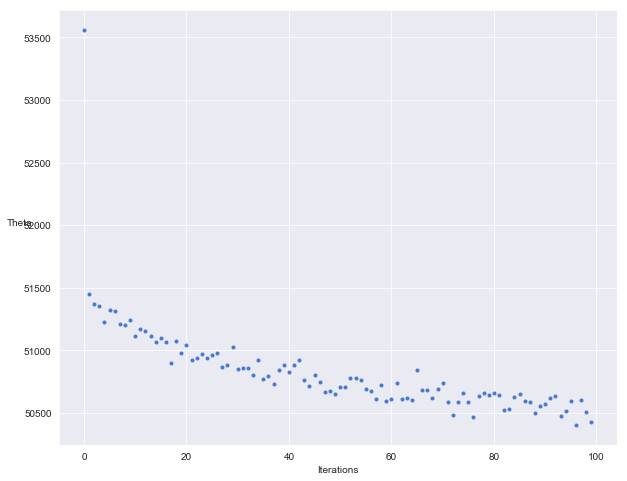

In [129]:
#Plot to find out the cost decrease gradually.
fig,ax = plt.subplots(figsize=(10,8))

ax.set_ylabel('Theta',rotation=0)
ax.set_xlabel('Iterations')
theta = np.random.randn(5,1)

_=ax.plot(range(n_iter),cost_history,'b.')

#### Support Vector Machine

In [107]:
print(df_17_model.info())
df_17_model.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72889 entries, 1001020100 to 72153750602
Data columns (total 28 columns):
TotalPop            72889 non-null int64
Women               72889 non-null float64
Hispanic            72889 non-null float64
White               72889 non-null float64
Black               72889 non-null float64
Native              72889 non-null float64
Asian               72889 non-null float64
Pacific             72889 non-null float64
VotingAgeCitizen    72889 non-null float64
Income              72889 non-null float64
Poverty             72889 non-null float64
ChildPoverty        72889 non-null float64
Professional        72889 non-null float64
Service             72889 non-null float64
Office              72889 non-null float64
Construction        72889 non-null float64
Production          72889 non-null float64
Drive               72889 non-null float64
Carpool             72889 non-null float64
Walk                72889 non-null float64
OtherTransp       

,TotalPop,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,SelfEmployed,FamilyWork,HighUnemployment
TractId,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1001020100,1845,51.3,2.4,86.3,5.2,0.0,1.2,0.0,76.3,67826.0,10.7,20.8,38.5,15.6,22.8,10.8,12.4,94.2,3.3,0.5,0.0,2.1,24.5,47.8,74.2,4.5,0.0,0
1001020200,2172,46.3,1.1,41.6,54.5,0.0,1.0,0.0,76.1,41287.0,22.4,35.8,30.5,24.9,22.9,6.3,15.4,90.5,9.1,0.0,0.5,0.0,22.2,39.2,75.9,9.0,0.0,0
1001020300,3385,54.7,8.0,61.4,26.5,0.6,0.7,0.4,73.3,46806.0,14.7,21.1,27.9,19.4,33.3,9.9,9.6,88.3,8.4,1.0,0.8,1.5,23.1,43.8,73.3,4.8,0.7,0
1001020400,4267,53.1,9.6,80.3,7.1,0.5,0.2,0.0,76.3,55895.0,2.3,1.7,29.0,16.6,25.8,9.1,19.5,82.3,11.2,1.5,2.9,2.1,25.9,43.3,75.8,4.5,0.0,1
1001020500,9965,49.3,0.9,77.5,16.4,0.0,3.1,0.0,72.5,68143.0,12.2,17.9,48.8,13.8,20.5,3.5,13.4,86.9,11.2,0.8,0.3,0.7,21.0,48.0,71.4,4.5,0.0,0


In [108]:
### Split into train and test set
import pandas as pd
from sklearn.model_selection import train_test_split

features = df_17_model.drop('HighUnemployment', axis=1)
labels = df_17_model['HighUnemployment']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [109]:
# Display to show that we got 80/20 split
for dataset in [y_train, y_test]:
    print(round(len(dataset) / len(labels), 2))

0.8
0.2


In [110]:
# Function to print the results
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

## Find the best tuned hyperplane parameters for Logistic Regression
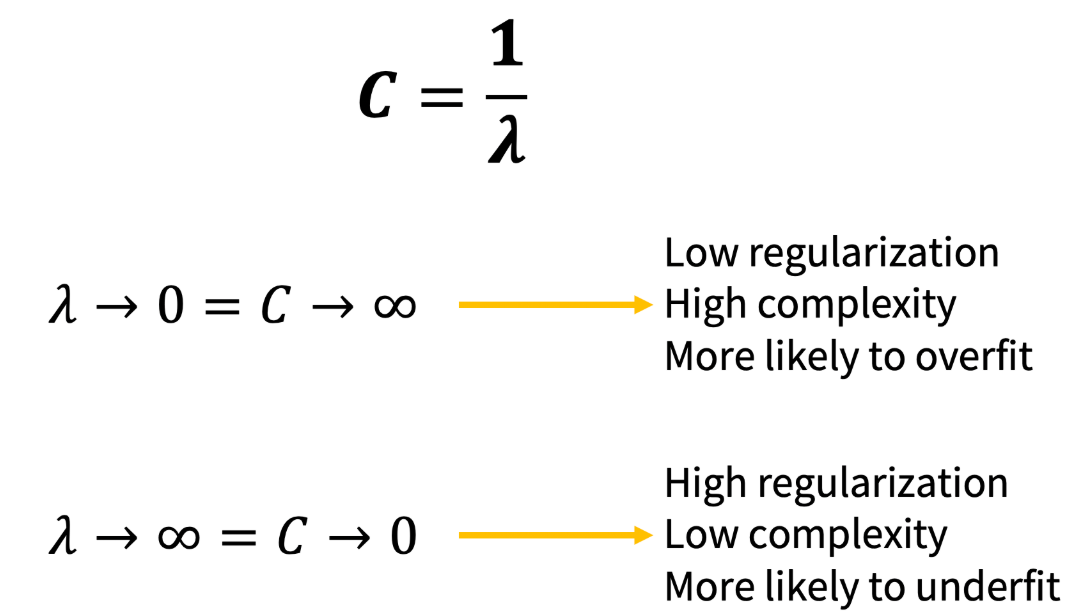

In [53]:
# Find the best hyperplane parameters for Logistic Regression
import joblib
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

lr = LogisticRegression()
parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

lr_cv = GridSearchCV(lr, parameters, cv=5)
lr_cv.fit(X_train, y_train.values.ravel())

print_results(lr_cv)

BEST PARAMS: {'C': 100}

0.746 (+/-0.008) for {'C': 0.001}
0.746 (+/-0.007) for {'C': 0.01}
0.746 (+/-0.007) for {'C': 0.1}
0.746 (+/-0.007) for {'C': 1}
0.746 (+/-0.007) for {'C': 10}
0.746 (+/-0.007) for {'C': 100}
0.745 (+/-0.008) for {'C': 1000}


In [54]:
# Display the best estimator with the recommended hyperplane parameters
lr_cv.best_estimator_

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [58]:
# Output this to a model.pkl file
joblib.dump(cv.best_estimator_, 'LR_full_model.pkl')

['LR_full_model.pkl']

## Find the best tuned hyperplane parameters for SVM
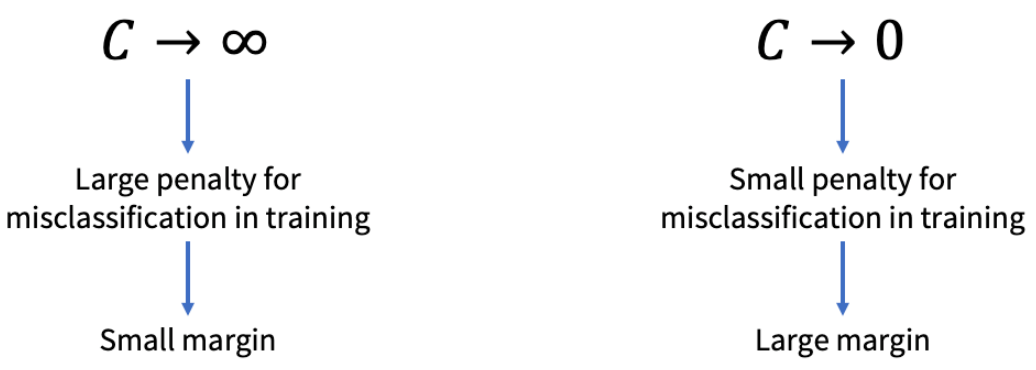

In [56]:
### Support Vector Machines: Fit and evaluate a model
import joblib
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [57]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [ ]:
#Note: This code is computationally very intensive and takes a long time. First we tried to see the best C value
# between 0.1, 1 and 10 with a cv of 5 but it was taking too many hours to finish so we decided to use a C of 0.5. 

svc = SVC()
parameters = {
    'kernel': ['linear', 'rbf'],
    'C': [0.5]
}

svm_cv = GridSearchCV(svc, parameters, cv=5)
svm_cv.fit(X_train, y_train.values.ravel())

print_results(svm_cv)

In [ ]:
svm_cv.best_estimator_

In [ ]:
joblib.dump(svm_cv.best_estimator_, 'SVM_full_model.pkl')

In [62]:
# Read in Models:
models = {}

for mdl in ['LR', 'SVM']:
    models[mdl] = joblib.load('{}_full_model.pkl'.format(mdl))

In [63]:
models

{'LR': LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=None, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
 'SVM': SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
   kernel='linear', max_iter=-1, probability=False, random_state=None,
   shrinking=True, tol=0.001, verbose=False)}

In [64]:
# Evaluate models on the test set
def evaluate_model(name, model, features, labels):
    start = time()
    pred = model.predict(features)
    end = time()
    accuracy = round(accuracy_score(labels, pred), 3)
    precision = round(precision_score(labels, pred), 3)
    recall = round(recall_score(labels, pred), 3)
    print('{} -- Accuracy: {} / Precision: {} / Recall: {} / Latency: {}ms'.format(name,
                                                                                   accuracy,
                                                                                   precision,
                                                                                   recall,
                                                                                   round((end - start)*1000, 1)))

In [65]:
import joblib
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score
from time import time

for name, mdl in models.items():
    evaluate_model(name, mdl, X_test, y_test)

LR -- Accuracy: 0.743 / Precision: 0.753 / Recall: 0.704 / Latency: 4.0ms
SVM -- Accuracy: 0.736 / Precision: 0.769 / Recall: 0.657 / Latency: 5427.4ms


In full model, Logistic Regression performed better with an accuracy of 74.3% and recall of 70.4%. However SVM performed better in precision with 76.9%. Latency for SVM is very high and is very slow to train.

# Reduced Model with features from PCA

The above analysis was performed on a dataset with 27 attributes, obtained from manual deletion of only a few variables. We recognize the dangers of overfitting with so many features being used, so we decided to reduce the dimensionality of our dataset greatly and run logistic and SVM models again. The features in this reduced dataset were selected based on PCA performed in Lab 1, i.e. 6 variables were chosen to explain the highest amount of variance in the dataset.

In [111]:
print(df_17_model.info())
df_17_model.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72889 entries, 1001020100 to 72153750602
Data columns (total 28 columns):
TotalPop            72889 non-null int64
Women               72889 non-null float64
Hispanic            72889 non-null float64
White               72889 non-null float64
Black               72889 non-null float64
Native              72889 non-null float64
Asian               72889 non-null float64
Pacific             72889 non-null float64
VotingAgeCitizen    72889 non-null float64
Income              72889 non-null float64
Poverty             72889 non-null float64
ChildPoverty        72889 non-null float64
Professional        72889 non-null float64
Service             72889 non-null float64
Office              72889 non-null float64
Construction        72889 non-null float64
Production          72889 non-null float64
Drive               72889 non-null float64
Carpool             72889 non-null float64
Walk                72889 non-null float64
OtherTransp       

,TotalPop,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,SelfEmployed,FamilyWork,HighUnemployment
TractId,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1001020100,1845,51.3,2.4,86.3,5.2,0.0,1.2,0.0,76.3,67826.0,10.7,20.8,38.5,15.6,22.8,10.8,12.4,94.2,3.3,0.5,0.0,2.1,24.5,47.8,74.2,4.5,0.0,0
1001020200,2172,46.3,1.1,41.6,54.5,0.0,1.0,0.0,76.1,41287.0,22.4,35.8,30.5,24.9,22.9,6.3,15.4,90.5,9.1,0.0,0.5,0.0,22.2,39.2,75.9,9.0,0.0,0
1001020300,3385,54.7,8.0,61.4,26.5,0.6,0.7,0.4,73.3,46806.0,14.7,21.1,27.9,19.4,33.3,9.9,9.6,88.3,8.4,1.0,0.8,1.5,23.1,43.8,73.3,4.8,0.7,0
1001020400,4267,53.1,9.6,80.3,7.1,0.5,0.2,0.0,76.3,55895.0,2.3,1.7,29.0,16.6,25.8,9.1,19.5,82.3,11.2,1.5,2.9,2.1,25.9,43.3,75.8,4.5,0.0,1
1001020500,9965,49.3,0.9,77.5,16.4,0.0,3.1,0.0,72.5,68143.0,12.2,17.9,48.8,13.8,20.5,3.5,13.4,86.9,11.2,0.8,0.3,0.7,21.0,48.0,71.4,4.5,0.0,0


In [112]:
#New features for PCA analysis
df_17_model['Income_thousands'] = df_17_model['Income'] / 1000

In [114]:
df_17_model.head()

,TotalPop,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,SelfEmployed,FamilyWork,HighUnemployment,Income_thousands
TractId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1001020100,1845,51.3,2.4,86.3,5.2,0.0,1.2,0.0,76.3,67826.0,10.7,20.8,38.5,15.6,22.8,10.8,12.4,94.2,3.3,0.5,0.0,2.1,24.5,47.8,74.2,4.5,0.0,0,67.826
1001020200,2172,46.3,1.1,41.6,54.5,0.0,1.0,0.0,76.1,41287.0,22.4,35.8,30.5,24.9,22.9,6.3,15.4,90.5,9.1,0.0,0.5,0.0,22.2,39.2,75.9,9.0,0.0,0,41.287
1001020300,3385,54.7,8.0,61.4,26.5,0.6,0.7,0.4,73.3,46806.0,14.7,21.1,27.9,19.4,33.3,9.9,9.6,88.3,8.4,1.0,0.8,1.5,23.1,43.8,73.3,4.8,0.7,0,46.806
1001020400,4267,53.1,9.6,80.3,7.1,0.5,0.2,0.0,76.3,55895.0,2.3,1.7,29.0,16.6,25.8,9.1,19.5,82.3,11.2,1.5,2.9,2.1,25.9,43.3,75.8,4.5,0.0,1,55.895
1001020500,9965,49.3,0.9,77.5,16.4,0.0,3.1,0.0,72.5,68143.0,12.2,17.9,48.8,13.8,20.5,3.5,13.4,86.9,11.2,0.8,0.3,0.7,21.0,48.0,71.4,4.5,0.0,0,68.143


In [115]:
# From PCA analysis done in Lab1, features "Income in thousands", "Drive", "Professional", "Private Work", 
# "Mean Commute" and "Service" are the predictor variables that act as a major role in 
# estabishing the principal components. 
#Income in thousands, Drive, Professional, Private Work, Mean Commute and Service 
del df_17_model['TotalPop'] 
del df_17_model['Women'] 
del df_17_model['Hispanic'] 
del df_17_model['White'] 
del df_17_model['Black'] 
del df_17_model['Native'] 
del df_17_model['Asian'] 
del df_17_model['Pacific'] 
del df_17_model['VotingAgeCitizen'] 
del df_17_model['Income'] 
del df_17_model['Poverty'] 
del df_17_model['ChildPoverty'] 
del df_17_model['Office'] 
del df_17_model['Construction'] 
del df_17_model['Production'] 
del df_17_model['Carpool'] 
del df_17_model['Walk'] 
del df_17_model['OtherTransp'] 
del df_17_model['WorkAtHome'] 
del df_17_model['Employed'] 
del df_17_model['SelfEmployed'] 
del df_17_model['FamilyWork'] 
df_17_model.head()

,Professional,Service,Drive,MeanCommute,PrivateWork,HighUnemployment,Income_thousands
TractId,,,,,,,
1001020100,38.5,15.6,94.2,24.5,74.2,0,67.826
1001020200,30.5,24.9,90.5,22.2,75.9,0,41.287
1001020300,27.9,19.4,88.3,23.1,73.3,0,46.806
1001020400,29.0,16.6,82.3,25.9,75.8,1,55.895
1001020500,48.8,13.8,86.9,21.0,71.4,0,68.143


In [116]:
### Split into train and test set
import pandas as pd
from sklearn.model_selection import train_test_split

features = df_17_model.drop('HighUnemployment', axis=1)
labels = df_17_model['HighUnemployment']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [117]:
# Show that we got 80/20 split
for dataset in [y_train, y_test]:
    print(round(len(dataset) / len(labels), 2))

0.8
0.2


In [118]:
# Function to print the results
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [13]:
# Find the best hyperplane parameters for Logistic Regression
import joblib
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

lr = LogisticRegression()
parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

lr_cv = GridSearchCV(lr, parameters, cv=5)
lr_cv.fit(X_train, y_train.values.ravel())

print_results(lr_cv)

BEST PARAMS: {'C': 0.1}

0.715 (+/-0.013) for {'C': 0.001}
0.716 (+/-0.014) for {'C': 0.01}
0.716 (+/-0.013) for {'C': 0.1}
0.716 (+/-0.014) for {'C': 1}
0.716 (+/-0.013) for {'C': 10}
0.716 (+/-0.013) for {'C': 100}
0.716 (+/-0.013) for {'C': 1000}


In [15]:
# Display the best estimator with the recommended hyperplane parameters for Logistic Regression
lr_cv.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [16]:
# Output this to a model.pkl file
joblib.dump(lr_cv.best_estimator_, 'LR_reduced_model.pkl')

['LR_reduced_model.pkl']

In [17]:
### Support Vector Machines: Fit and evaluate a model
import joblib
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [18]:
#Note: This code is computationally very intensive and takes a long time. First we tried to see the best C value
# between 0.1, 1 and 10 with a cv of 5 but it was taking too long so we decided to use a C of 0.5. 

svc = SVC()
parameters = {
    'kernel': ['linear', 'rbf'],
    'C': [0.5]
}

svm_cv = GridSearchCV(svc, parameters, cv=5)
svm_cv.fit(X_train, y_train.values.ravel())

print_results(svm_cv)

BEST PARAMS: {'C': 0.5, 'kernel': 'linear'}

0.715 (+/-0.012) for {'C': 0.5, 'kernel': 'linear'}
0.532 (+/-0.002) for {'C': 0.5, 'kernel': 'rbf'}


Linear kernel performed better than "rbf". 

In [19]:
# Display the best estimator with the recommended hyperplane parameters
svm_cv.best_estimator_

SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [20]:
# Output this to a model.pkl file
joblib.dump(svm_cv.best_estimator_, 'SVM_reduced_model.pkl')

['SVM_reduced_model.pkl']

In [27]:
# Read in Models:
reduced_models = {}

for mdl in ['LR', 'SVM']:
    reduced_models[mdl] = joblib.load('{}_reduced_model.pkl'.format(mdl))

In [28]:
reduced_models

{'LR': LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=None, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
 'SVM': SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
   kernel='linear', max_iter=-1, probability=False, random_state=None,
   shrinking=True, tol=0.001, verbose=False)}

In [29]:
# Evaluate models on the test set
def evaluate_model(name, model, features, labels):
    start = time()
    pred = model.predict(features)
    end = time()
    accuracy = round(accuracy_score(labels, pred), 3)
    precision = round(precision_score(labels, pred), 3)
    recall = round(recall_score(labels, pred), 3)
    print('{} -- Accuracy: {} / Precision: {} / Recall: {} / Latency: {}ms'.format(name,
                                                                                   accuracy,
                                                                                   precision,
                                                                                   recall,
                                                                                   round((end - start)*1000, 1)))

In [30]:
import joblib
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score
from time import time

for name, mdl in reduced_models.items():
    evaluate_model(name, mdl, X_test, y_test)

LR -- Accuracy: 0.711 / Precision: 0.694 / Recall: 0.731 / Latency: 3.0ms
SVM -- Accuracy: 0.709 / Precision: 0.688 / Recall: 0.74 / Latency: 3738.4ms


In the reduced model with features from PCA, Logistic Regression performed better with an accuracy of 71.1% and precision of 69.4%. However SVM performed better in recall with 74%. Latency for SVM is very high and is very slow to train.

<div class="alert alert-block alert-info">
<b>Rubric 2:</b> Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.
</div>

### Model Advantages

In [ ]:
import joblib
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score
from time import time

for name, mdl in models.items():
    evaluate_model(name, mdl, X_test, y_test)

In our case Logistic Regression performed better with an accuracy of 74.3% and recall of 70.4%. However SVM performed better in Precision. Latency for SVM is very high and is very slow to train.

Logistic Regression: 

When to use LR:
- Binary target variable
- Transparency is important or interested in significance of predictors
- Fairly well-behaved data
- Need a quick initial benchmark

Logistic Regression can be considered any time we have a binary target variable and if we are interested in feature importance or to have a better understanding of what's going on within the algorithm. It should be considered when there are not too many outliers, not too many missing values, and relationships that aren't too complex. It is great for as an initial benchmark model on a binary classification problem with fairly well-behaved data. It's relatively flexible, and it's very fast to train. While it doesn't usually generate the greatest performance, it does set a very nice benchmark to start.

When not to use LR:
- Continuous target variable
- Massive data (rows or columns)
- Unwieldy data
- Performance is the only thing that matters

Logistic Regression should not be considered when we have a continuous target variable. Logistic regression also shouldn't be the first choice if we have a massive amount of data. There are other algorithms that really shine when we have a ton of data. Logistic regression is a great tool for a fast, transparent baseline model for a binary classification problem. It doesn't do well with a lot of data or particularly messy data. It's also unlikely to give you the best possible performance on any given problem.


Support Vector Machines:

When to use SVM:

- Binary target variable
- Feature to row ratio is very high
- Very complex relationships
- Lots of outliers

SVM can be used for both categorical and continuous outputs. One area where SVM really excels is when the feature-to-row ratio is very high. It's when you have a lot of features and relatively few rows. SVM is also quite good at untangling complex relationships. SVM also handles data with a lot of outliers quite well, because it only looks at the points closest to the line, so that outliers are kind of ignored. 

When not to use SVM:

- Feature to row ratio is very low
- Transparency is important or interested in significance of predictors
- Looking for a quick benchmark model

SVM should not be used if there are lot of rows and relatively few features. Typically, SVM will take a long time to train, and the performance really won't be worth it relative to other algorithms. Since in SVM hyperplane is an extremely high-dimensional space, you can't really get a good picture what's going on inside of SVM. So if you care about transparency, and maybe the significance of predictors, you should avoid SVM. SVM should be used when you have a lot of features, but few rows, or when you have a lot of outliers, that you're trying to untangle. But it is quite slow to train.

### Interpret Feature Importance

<div class="alert alert-block alert-info">
<b>Rubric 3:</b> Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?
</div>

In [124]:
# TODO use best logistic model we find (lr_clf object)
# sort attributes by weight and spit them out
zip_vars = zip(lr_clf.coef_.T,df_17_model.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

MeanCommute has weight of -1.139994792607686
Drive has weight of -0.5003321357866518
PrivateWork has weight of -0.3352417660120973
Income_thousands has weight of -0.23293817394402824
HighUnemployment has weight of -0.056611751457627806
Professional has weight of -0.036977198847472935
Service has weight of 0.0669037884333861


In [ ]:
weights = pd.Series(lr_clf.coef_[0],index=df_17_model.columns)
weights.plot(kind='bar')
plt.show()

### Interpret Support Vectors

<div class="alert alert-block alert-info">
<b>Rubric 4:</b> Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.
</div>

In [119]:
svm_reduced_model = joblib.load('SVM_reduced_model.pkl'.format(mdl))

In [120]:
# look at the support vectors
print(svm_reduced_model.support_vectors_.shape)
print(svm_reduced_model.support_.shape)
print(svm_reduced_model.n_support_ )

(39410, 6)
(39410,)
[19705 19705]


[[-0.0199995   0.03094172 -0.00562726  0.05093269 -0.01379212 -0.02925393]]


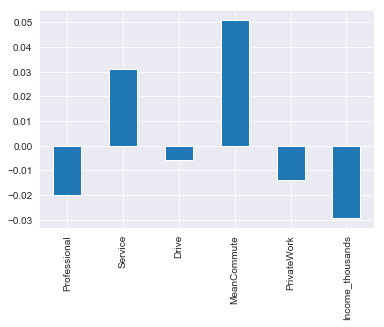

In [121]:
# if using linear kernel, these make sense to look at (not otherwise, why?)
print(svm_reduced_model.coef_)
weights = pd.Series(svm_reduced_model.coef_[0],index=features.columns)
weights.plot(kind='bar')

In [122]:
# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors

# now lets look at the support for the vectors and see if we they are indicative of anything
# grabe the rows that were selected as support vectors (these are usually instances that are hard to classify)

# make a dataframe of the training data
df_tested_on = features.iloc[train_indices] # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_reduced_model.support_,:]

df_support['HighUnemployment'] = y[svm_reduced_model.support_] # add back in the 'Survived' Column to the pandas dataframe
features['HighUnemployment'] = y # also add it back in for the original data
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39410 entries, 48201332500 to 39145003400
Data columns (total 7 columns):
Professional        39410 non-null float64
Service             39410 non-null float64
Drive               39410 non-null float64
MeanCommute         39410 non-null float64
PrivateWork         39410 non-null float64
Income_thousands    39410 non-null float64
HighUnemployment    39410 non-null int64
dtypes: float64(6), int64(1)
memory usage: 2.4 MB


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


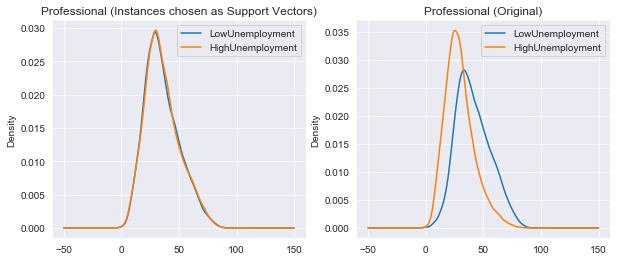

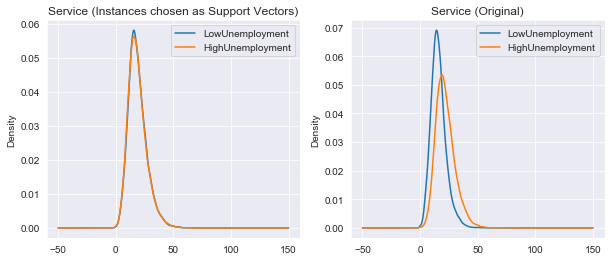

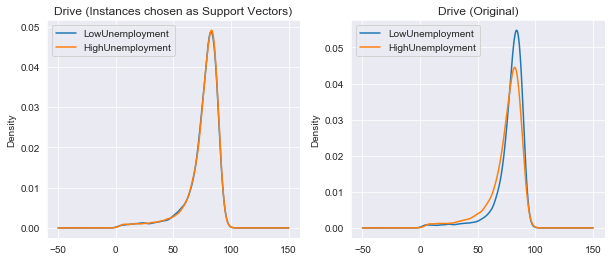

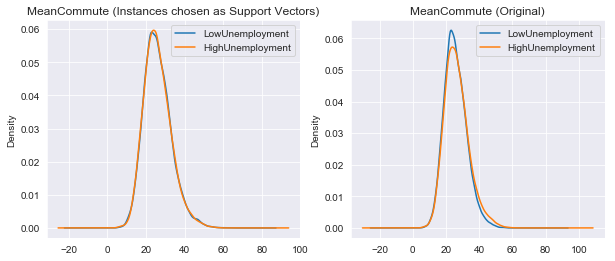

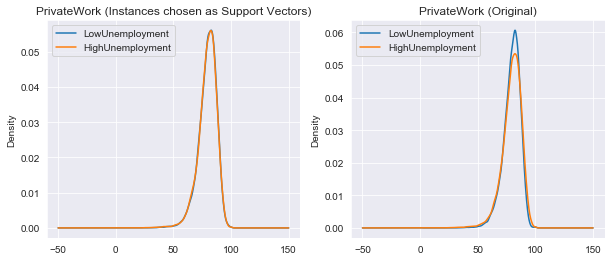

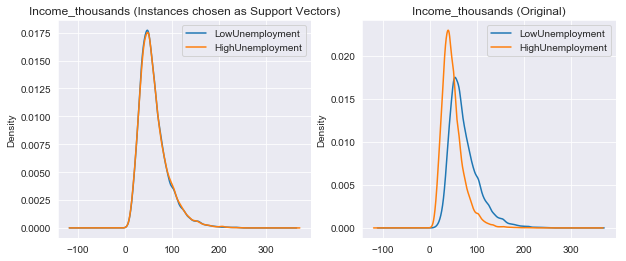

In [123]:
# now lets see the statistics of these attributes
#from pandas.tools.plotting import boxplot
import matplotlib.pyplot as plt

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['HighUnemployment'])
df_grouped = features.groupby(['HighUnemployment'])

# plot KDE of Different variables
vars_to_plot = ['Professional','Service','Drive','MeanCommute','PrivateWork','Income_thousands']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['LowUnemployment','HighUnemployment'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['LowUnemployment','HighUnemployment'])
    plt.title(v+' (Original)')